In [1]:
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing import image
from PIL import Image
import os
from tensorflow.keras.applications import resnet

In [2]:
def parse_output(heatmap_data,offset_data, threshold):

    '''
    Input:
        heatmap_data - hetmaps for an image. Three dimension array
        offset_data - offset vectors for an image. Three dimension array
        threshold - probability threshold for the keypoints. Scalar value
    Output:
        array with coordinates of the keypoints and flags for those that have
        low probability
    '''

    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,3), np.uint32)

    for i in range(heatmap_data.shape[-1]):

        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap))[0])
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
        max_prob = np.max(joint_heatmap)

        if max_prob > threshold:
            if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
                pose_kps[i,2] = 1

    return pose_kps

In [3]:
def fullpose_model_setup():
    path = "./Full_pose/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    return interpreter

In [4]:
def get_fullpose_img(interpreter,image_path='./Sample/sample.jpg'):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2] 
    #reading of query image
    template_input = cv2.imread(image_path)
    template_input = cv2.resize(template_input, (width, height),interpolation = cv2.INTER_AREA)
    template_input = np.expand_dims(template_input, axis=0)
    # check the type of the input tensor
    if input_details[0]['dtype'] == np.float32:
        # Brings input values to range from 0 to 1
        template_input = (np.float32(template_input)/ 255.0)
    # Process template image
    # Sets the value of the input tensor
    interpreter.set_tensor(input_details[0]['index'], template_input)
    # Runs the computation
    interpreter.invoke()
    # Extract output data from the interpreter
    template_heatmaps = interpreter.get_tensor(output_details[0]['index'])
    template_offsets = interpreter.get_tensor(output_details[1]['index'])
    # Getting rid of the extra dimension
    template_heatmaps = np.squeeze(template_heatmaps)
    template_offsets = np.squeeze(template_offsets)
    #print("template_heatmaps' shape:", template_heatmaps.shape)
    #print("template_offsets' shape:", template_offsets.shape)
    template_show = np.squeeze((template_input.copy()))
    template_show = np.array(template_show*255,np.uint8)
    template_kps = parse_output(template_heatmaps,template_offsets,0.3)
    if (template_kps[0][2]==1) and ((template_kps[1][2] or template_kps[2][2]) ==1) and ((template_kps[11][2] or template_kps[12][2]) ==1) and ((template_kps[15][2] or template_kps[16][2]) ==1):
        return True
    else:
        return False

In [5]:
def object_detection_setup(configPath='/Users/suraj/Desktop/BMTL/deployment/Darknet/yolov4_test.cfg',weightsPath='/Users/suraj/Desktop/BMTL/deployment/Darknet/yolov4_train_best.weights'):
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    categories=['bags','belts','dresses','eyewear','footwear','hats','leggings','outerwear','pants','skirts','tops']
    
    return net,ln,categories

In [6]:
def object_detection_pipeline(net,ln,categories,image_path='./Sample/sample.jpg'):
    img=np.array(image.load_img(image_path, grayscale=False, color_mode='rgb', target_size=(608,608),interpolation='nearest'))
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (608, 608),swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    confidences = []
    classIDs = []
    boxes=[]
    threshold = 0.1
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence >threshold :
                box = detection[0:4] * np.array([608, 608, 608, 608])
                (centerX, centerY, width, height) = box.astype("int")           
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))    
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)
    cats=[]
    
    if len(idxs) > 0:
        figure, ax = plt.subplots(1)
        for idx,i in enumerate(idxs.flatten()):
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            
            if categories[classIDs[i]] not in cats:
                im = Image.fromarray(img)
                im=im.crop((x,y,x+w,y+h))
                im.save('./Sample/crop/sample'+str(idx)+'.jpg')
                cats.append(categories[classIDs[i]])
            rect=patches.Rectangle((x,y),w,h, edgecolor='y', facecolor="none")
            ax.add_patch(rect)
            ax.text(x, y,categories[classIDs[i]] , style='normal',bbox={'facecolor': 'yellow', 'alpha': 1, 'pad': 2})
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    ax.imshow(img)
    plt.show()
    return cats

In [7]:
def triplet_setup():
    embedding = tf.keras.models.load_model("./Triplet/final")
    cat_to_emb = np.load('./Triplet/emb.npy',allow_pickle='TRUE').item()
    return embedding,cat_to_emb

In [60]:
def path_to_embs(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    out=embedding(resnet.preprocess_input(x))
    return out
def get_simalar_image(image_vetor,image_type):
    path_to_emb=cat_to_emb[image_type]
    embs= tf.convert_to_tensor(list(path_to_emb.values()), dtype=tf.float32)
    num=tf.matmul(embs,image_vetor,transpose_b=True)
    p=tf.linalg.normalize(embs,axis=-1)[1]
    q=tf.linalg.normalize(image_vetor,axis=-1)[1]
    den=tf.matmul(p,q,transpose_b=True)
    similarity_values=tf.math.divide(num, den)
    similarity_values=tf.squeeze(similarity_values, axis=-1)
    idx=np.argpartition(similarity_values,axis=0,kth=-6)[-6:]
    simalar_path=[]
    for i in idx[-6:]:
        simalar_path.append(list(path_to_emb.keys())[i[0]])
    return simalar_path
def draw_images_from_path(paths,title):
    fig = plt.figure(figsize=(12, 12))
    #fig.suptitle(title)
    ax = fig.subplots(1,len(paths))
    #ax.set_title('simillar')
    for i in range(len(paths)):
        path="../"+paths[i]
        img=image.load_img(path, target_size=(220, 220))
        ax[i].set_title(title+" "+str(i))
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        ax[i].imshow(img)
    plt.show()
    

In [61]:
def prdict(Ouery_path,cat):
    Query_img_type=cat
    Query_emb=path_to_embs(Ouery_path)
    pred_img=get_simalar_image(Query_emb,Query_img_type)
    fig = plt.figure()
    #fig.suptitle(cat)
    img=image.load_img(Ouery_path, target_size=(256, 256))
    #plt.imshow(img)
    draw_images_from_path(pred_img,'simillar '+cat)
    plt.show()

In [62]:
def pred_look(imgpath):
    fullpose=get_fullpose_img(interpreter,imgpath)
    if fullpose:
        cats=object_detection_pipeline(net,ln,categories,imgpath)
        articles=["./Sample/crop/"+i for i in os.listdir("./Sample/crop/")[:len(cats)]]
        for i in range(len(articles)):
            prdict(articles[i],cats[i])

In [63]:
interpreter=fullpose_model_setup()
net,ln,categories=object_detection_setup()
embedding,cat_to_emb=triplet_setup()

2021-08-12 12:25:22.896 No training configuration found in save file, so the model was *not* compiled. Compile it manually.


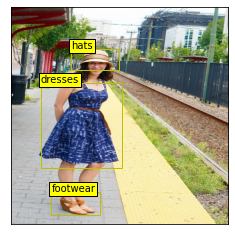

<Figure size 432x288 with 0 Axes>

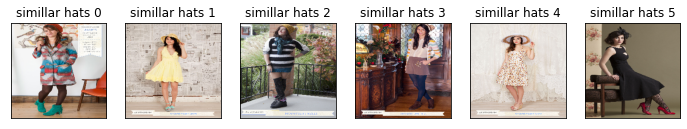

<Figure size 432x288 with 0 Axes>

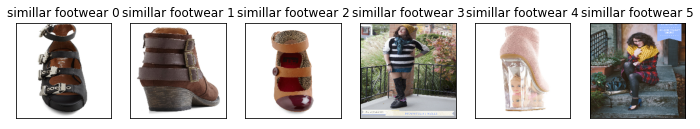

<Figure size 432x288 with 0 Axes>

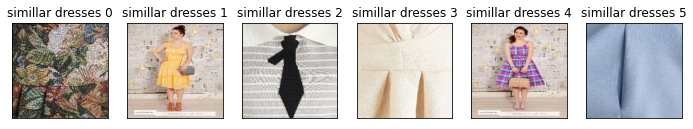

In [64]:
pred_look("../Dataset/street2shop/images/11277.jpg")